In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
#preprocessing

lnames = ['movie_id','imdb_id','tmdb_id']
links = pd.read_csv('ml-latest-small/links.csv', sep=',', header=None, names=lnames)

rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('ml-latest-small/ratings.csv', sep=',', header=None, names=rnames)

mnames = ['movie_id', 'title', 'genres']
movies = pd.read_csv('ml-latest-small/movies.csv', sep=',', header=None, names=mnames)

In [3]:
data = pd.merge(pd.merge(movies, ratings), links)
data = data.drop([0])#first row is labels
data[:5]

,movie_id,title,genres,user_id,rating,timestamp,imdb_id,tmdb_id
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,0114709,862
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,0114709,862
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946,0114709,862
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970,0114709,862
5,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483,0114709,862


In [4]:
#Each movie average rating
data['rating'] = data['rating'].astype(float)
data['timestamp'] = data['timestamp'].astype(int)
mean_ratings = data.pivot_table(values='rating', index='title', aggfunc='mean')
mean_ratings

,rating
title,
'71 (2014),4.000000
'Hellboy': The Seeds of Creation (2004),4.000000
'Round Midnight (1986),3.500000
'Salem's Lot (2004),5.000000
'Til There Was You (1997),4.000000
...,...
eXistenZ (1999),3.863636
xXx (2002),2.770833
xXx: State of the Union (2005),2.000000


In [5]:
#Highest rated movies
top_movies = mean_ratings.sort_values(['rating'], ascending=False)
top_movies[:10]

,rating
title,
Gena the Crocodile (1969),5.0
True Stories (1986),5.0
Cosmic Scrat-tastrophe (2015),5.0
Love and Pigeons (1985),5.0
Red Sorghum (Hong gao liang) (1987),5.0
"Thin Line Between Love and Hate, A (1996)",5.0
Lesson Faust (1994),5.0
Eva (2011),5.0
Who Killed Chea Vichea? (2010),5.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe4f81feb50>]],
      dtype=object)

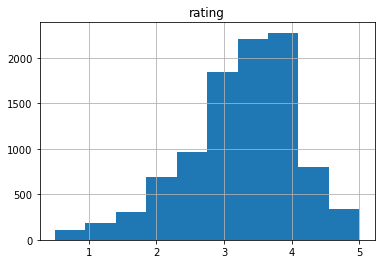

In [12]:
top_movies.hist(bins=10)

In [8]:
#removing outliers 
ratings_by_title = data.groupby('movie_id').size()
ratings_by_title = pd.DataFrame(ratings_by_title, columns = ['n_ratings'])
ratings_by_title = pd.merge(ratings_by_title, movies, on='movie_id')
ratings_by_title = ratings_by_title.drop(columns=['genres'])
ratings_by_title = ratings_by_title.set_index('title')
ratings_by_title['n_ratings'] = ratings_by_title['n_ratings'].astype(int)
ratings_by_title

,movie_id,n_ratings
title,,
Toy Story (1995),1,215
GoldenEye (1995),10,132
City Hall (1996),100,14
Human Planet (2011),100044,1
Comme un chef (2012),100068,1
...,...,...
Codependent Lesbian Space Alien Seeks Same (2011),99853,1
2 Days in the Valley (1996),999,12
"Last Stand, The (2013)",99910,2


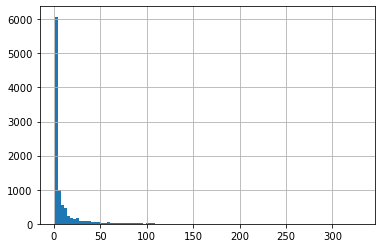

In [9]:
ratings_by_title['n_ratings'].hist(bins = 100)

In [10]:
#titles with atleast 10% of the number of ratings as the most rated movie
min_ratings = max(ratings_by_title['n_ratings'])*0.1
min_ratings = int(min_ratings)
print("minimum number of ratings: "+str(min_ratings))
active_titles = ratings_by_title.index[ratings_by_title['n_ratings'] > min_ratings]
active_titles

minimum number of ratings: 32


Index(['Toy Story (1995)', 'GoldenEye (1995)', 'Cool Runnings (1993)',
       'Cinderella (1950)', 'Mary Poppins (1964)', 'Dumbo (1941)',
       'Alice in Wonderland (1951)', 'Sound of Music, The (1965)',
       'Die Hard (1988)', 'Happy Gilmore (1996)',
       ...
       'Gone with the Wind (1939)', 'Intouchables (2011)',
       'Citizen Kane (1941)', '2001: A Space Odyssey (1968)',
       'Broken Arrow (1996)', 'It's a Wonderful Life (1946)', 'Skyfall (2012)',
       'African Queen, The (1951)',
       'Hobbit: An Unexpected Journey, The (2012)', 'Django Unchained (2012)'],
      dtype='object', name='title', length=806)

In [13]:
#Highest rated movies with enough ratings to qualify
mean_ratings = mean_ratings.loc[active_titles]
mean_ratings = mean_ratings.sort_values(by='rating', ascending=False)
mean_ratings

,rating
title,
"Shawshank Redemption, The (1994)",4.429022
Lawrence of Arabia (1962),4.300000
"Godfather, The (1972)",4.289062
Fight Club (1999),4.272936
Cool Hand Luke (1967),4.271930
...,...
"Flintstones, The (1994)",2.357143
Hollow Man (2000),2.294872
Batman & Robin (1997),2.214286


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe4f825ffa0>]],
      dtype=object)

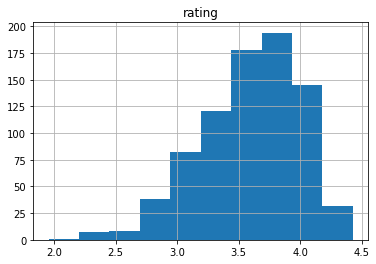

In [14]:
mean_ratings.hist(bins=10)

In [15]:
#Data Encoding: each user and their movie ratings
data['user_id'] = data['user_id'].astype(str).astype(int)
sorted_by_user = data.sort_values(by = 'user_id')
sorted_by_user

,movie_id,title,genres,user_id,rating,timestamp,imdb_id,tmdb_id
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,0114709,862
35549,1777,"Wedding Singer, The (1998)",Comedy|Romance,1,4.0,964981230,0120888,11003
35250,1732,"Big Lebowski, The (1998)",Comedy|Crime,1,5.0,964981125,0118715,115
34349,1676,Starship Troopers (1997),Action|Sci-Fi,1,3.0,964982620,0120201,563
2380,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,1,5.0,964982931,0114814,629
...,...,...,...,...,...,...,...,...
71057,6387,Once a Thief (Zong heng si hai) (1991),Action|Comedy|Crime|Thriller,610,3.5,1479542038,0101020,47423
87455,59915,Stuck (2007),Horror|Thriller,610,3.5,1493848708,0758786,13848
97037,111663,Zombeavers (2014),Action|Comedy|Horror,610,3.5,1493848822,2784512,254474
98182,122886,Star Wars: Episode VII - The Force Awakens (2015),Action|Adventure|Fantasy|Sci-Fi|IMAX,610,4.5,1479544589,2488496,140607


In [29]:
n_users = data.user_id.unique().shape[0]
print(n_users, ' users')
n_movies = data.title.unique().shape[0]
print(n_movies, 'movies')
ratings_matrix = sorted_by_user.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)
ratings_matrix

610  users
9719 movies


movie_id,1,10,100,100044,100068,100083,100106,100159,100163,100194,...,99750,99764,998,99813,99846,99853,999,99910,99917,99992
user_id,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
R = np.array(ratings_matrix)
sparsity = float(len(R.nonzero()[0]))
sparsity /= (R.shape[0] * R.shape[1])
sparsity *= 100
print('Sparsity: {:.2f}%'.format(sparsity))

Sparsity: 1.70%


In [18]:
#Train and test matrix fact. adapted from towardsdatascience
def train_test_split(ratings):
    
    validation = np.zeros(ratings.shape)
    train = ratings.copy()
    
    for user in np.arange(ratings.shape[0]):
        if len(ratings[user,:].nonzero()[0]) > 0:#every user that has rated a movie
            val_ratings = np.random.choice(
                ratings[user, :].nonzero()[0], 
                size=3,#remove 3 ratings
                replace=False
            )
            train[user, val_ratings] = 0
            validation[user, val_ratings] = ratings[user, val_ratings]
    return train, validation

In [19]:
train, val = train_test_split(R)

train

array([[4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 4., 0., ..., 0., 0., 0.],
       [3., 4., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 3., 0.]])

In [20]:
def rmse(prediction, actual_rating):
    prediction = prediction[actual_rating.nonzero()].flatten() 
    actual_rating = actual_rating[actual_rating.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, actual_rating))

In [21]:
def predict(X_train, X_val, n_iters=200, n_latent_features=3, lmbda=0.1, learning_rate=0.001):
    m, n = X_train.shape

    P = 3 * np.random.rand(n_latent_features, m)
    Q = 3 * np.random.rand(n_latent_features, n)
    
    train_error = []
    val_error = []

    users, movies = X_train.nonzero()
    
    for epoch in range(n_iters):
        for u, i in zip(users, movies):
            error = X_train[u, i] -  np.dot(P[:,u],  Q[:,i])
            P[:, u] +=  learning_rate * (error *  Q[:, i] -  lmbda *  P[:, u])
            Q[:, i] +=  learning_rate * (error *  P[:, u] -  lmbda *  Q[:, i])

        train_rmse = rmse(np.dot(P.T, Q), X_train)
        val_rmse = rmse(np.dot(P.T, Q), X_val)
        train_error.append(train_rmse)
        val_error.append(val_rmse)
        
    return np.dot(P.T, Q) , train_error, val_error

In [22]:
prediction, t_err, v_err = predict(train, val)

prediction.shape

(610, 9724)

In [23]:
err = rmse(np.array(prediction), R)
print(err)

0.8380911376385736


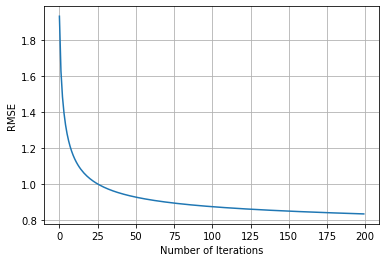

In [24]:
plt.plot(range(200), t_err)
plt.xlabel('Number of Iterations');
plt.ylabel('RMSE')
plt.grid()
plt.show()

In [25]:
prediction = pd.DataFrame(data = prediction, index = ratings_matrix.index, columns =ratings_matrix.columns)

prediction

movie_id,1,10,100,100044,100068,100083,100106,100159,100163,100194,...,99750,99764,998,99813,99846,99853,999,99910,99917,99992
user_id,,,,,,,,,,,,,,,,,,,,,
1,4.566710,4.052116,3.358174,4.674742,6.404619,3.957282,4.650950,6.013407,4.268872,4.088368,...,4.118188,5.390161,4.210489,5.008049,4.385601,4.656765,3.671864,4.696208,4.946185,6.648906
2,3.740260,3.335797,2.541745,4.238730,5.338063,2.581269,4.471161,4.871790,3.452699,2.809978,...,3.421188,4.513296,3.387196,4.233938,3.436109,3.945476,2.602267,3.893501,4.469766,5.572325
3,2.413294,2.107791,1.197508,2.833026,3.318370,2.098748,2.963798,3.608815,1.830338,1.559423,...,2.726401,2.543373,2.180260,3.111799,1.631756,2.645947,2.105590,1.950838,3.151364,3.330636
4,3.510722,3.140243,2.800230,3.575174,4.998287,2.757220,3.587797,4.370558,3.489888,3.233890,...,2.893402,4.348277,3.234624,3.658439,3.670502,3.537345,2.562294,3.913189,3.694390,5.262881
5,3.771762,3.376782,3.140297,3.713921,5.366584,3.065613,3.662996,4.630242,3.829118,3.662617,...,3.006749,4.708155,3.492522,3.829877,4.085492,3.747846,2.788804,4.287513,3.810693,5.665421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,3.596440,3.181480,2.611123,3.628456,5.009050,3.293104,3.564852,4.816448,3.307823,3.270175,...,3.315254,4.171648,3.325295,3.980641,3.389428,3.660960,3.024914,3.603971,3.866893,5.174320
607,3.967106,3.537927,3.073448,4.046683,5.616631,3.236369,4.047402,5.044274,3.856715,3.617653,...,3.383270,4.827849,3.656208,4.213732,4.023121,4.014663,3.005234,4.295218,4.218751,5.883452
608,3.606366,3.173143,2.480916,3.637477,4.970652,3.511498,3.545161,4.997889,3.181094,3.236668,...,3.502573,4.045088,3.337939,4.113696,3.206617,3.694914,3.218175,3.412612,3.935290,5.084624


In [26]:
#highest rated predictions
highest_prediction = prediction.mean(axis=0)
highest_prediction = pd.DataFrame(data = highest_prediction,index = ratings_matrix.columns, columns = ['predicted_rating'])
highest_prediction = pd.merge(highest_prediction, movies, on='movie_id')
highest_prediction = highest_prediction.set_index(['title'])
highest_prediction = highest_prediction.sort_values(by = 'predicted_rating', ascending = False)
highest_prediction

,movie_id,predicted_rating,genres
title,,,
Trinity and Sartana Are Coming (1972),128087,7.252422,Comedy|Western
Looker (1981),5764,7.034656,Drama|Horror|Sci-Fi|Thriller
"Very Potter Sequel, A (2010)",93008,6.823969,Comedy|Musical
George Carlin: Life Is Worth Losing (2005),130970,6.777491,Comedy
"McFarland, USA (2015)",129659,6.768528,Drama
...,...,...,...
Bartleby (2001),27306,0.981336,Comedy|Drama
2 Days in New York (2012),95744,0.977380,Comedy
Pokemon 4 Ever (a.k.a. Pokémon 4: The Movie) (2002),5672,0.886627,Adventure|Animation|Children|Fantasy


In [27]:
highest_prediction = highest_prediction.drop(columns = ['genres'])
highest_prediction = highest_prediction.loc[active_titles]
highest_prediction = highest_prediction.sort_values(by = 'predicted_rating', ascending = False)
highest_prediction[:5]

,movie_id,predicted_rating
title,,
Lawrence of Arabia (1962),1204,4.373775
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964),750,4.303190
Rear Window (1954),904,4.255433
Patton (1970),1272,4.230089
"Shawshank Redemption, The (1994)",318,4.219044


In [28]:
#comparing to original data
ratings_comparison = mean_ratings.merge(highest_prediction, on='title', how='left')
ratings_comparison['%_diff'] = ((ratings_comparison['rating'] - ratings_comparison['predicted_rating'])/ratings_comparison['rating'])*100
ratings_comparison = ratings_comparison[['movie_id', 'rating','predicted_rating','%_diff']]
ratings_comparison

,movie_id,rating,predicted_rating,%_diff
title,,,,
"Shawshank Redemption, The (1994)",318,4.429022,4.219044,4.740950
Lawrence of Arabia (1962),1204,4.300000,4.373775,-1.715704
"Godfather, The (1972)",858,4.289062,4.161211,2.980868
Fight Club (1999),2959,4.272936,4.163651,2.557605
Cool Hand Luke (1967),1276,4.271930,4.159503,2.631751
...,...,...,...,...
"Flintstones, The (1994)",355,2.357143,2.365323,-0.347021
Hollow Man (2000),3826,2.294872,2.408634,-4.957228
Batman & Robin (1997),1562,2.214286,2.182150,1.451298


In [30]:
user_predict = prediction.filter(items=highest_prediction['movie_id'])
user_predict

movie_id,1204,750,904,1272,318,1208,1199,1201,3275,912,...,44,455,762,3826,355,193,435,2701,1562,1882
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.241498,5.191073,5.135936,5.012992,5.061324,5.033156,5.038154,5.012428,5.018920,5.015646,...,3.055258,3.026619,3.003199,2.961387,2.874384,2.819496,2.903453,2.613802,2.607381,2.537749
2,4.517186,4.234318,4.237507,3.756979,4.134603,4.166275,4.133006,4.045835,4.073633,4.095866,...,2.518412,2.731539,2.325923,2.576918,2.396559,2.369776,2.552491,2.357670,2.135954,2.299055
3,3.244240,2.602000,2.649619,2.363559,2.691461,2.703029,2.562760,2.555945,2.544548,2.590330,...,1.499773,1.755219,0.968975,1.495443,1.428791,1.701636,1.504591,1.964554,1.450549,1.195767
4,3.872271,4.058581,3.995892,3.857408,3.877439,3.865003,3.929068,3.877530,3.899994,3.882775,...,2.416768,2.351353,2.581051,2.378138,2.275807,2.080544,2.322221,1.791028,1.965934,2.122273
5,4.043455,4.387270,4.299118,4.248416,4.164580,4.138010,4.237219,4.191173,4.214279,4.183697,...,2.613559,2.459454,2.899945,2.542834,2.453737,2.189424,2.472304,1.789989,2.099606,2.269954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,4.141416,4.070959,4.026524,3.996585,3.991416,3.958759,3.950581,3.948942,3.945789,3.943916,...,2.384136,2.340423,2.305332,2.281196,2.238497,2.237011,2.235585,2.090779,2.064497,1.917496
607,4.440774,4.557871,4.495394,4.358226,4.387172,4.369132,4.416457,4.371654,4.389682,4.376304,...,2.702492,2.646114,2.803149,2.644492,2.543940,2.387199,2.586003,2.114548,2.237594,2.326025
608,4.249274,4.037992,4.005260,4.016523,4.011700,3.971102,3.924392,3.945833,3.930421,3.937433,...,2.345351,2.322488,2.136432,2.215631,2.199721,2.298596,2.176654,2.233556,2.095590,1.802648


In [41]:
user_recommendation = []
for user, rating in user_predict.iterrows():
    recommend_movies = []
    rating.sort_values()
    n=1
    while len(recommend_movies) < 5: #recommend 5 unseen popular movies to each user
        col = str(rating.index[n])
        seen = ratings_matrix.loc[user,[col]].array
        if seen[0] == 0:
            recommend_movies.append(rating.index[n])
        n+=1
    user_recommendation.append(recommend_movies)

In [45]:
user_recommendation = pd.DataFrame(data = user_recommendation, index=ratings_matrix.index)
user_recommendation

,0,1,2,3,4
user_id,,,,,
1,750,904,1272,318,1199
2,750,904,1272,1208,1199
3,750,904,318,1208,1199
4,750,1272,318,1208,1201
5,750,904,1272,1208,1199
...,...,...,...,...,...
606,1272,3275,1276,1228,1252
607,750,904,1272,1208,1199
608,904,1272,1199,1201,912


In [65]:
#looking up a user's recommended movies by name
random_user = user_recommendation.loc[353]
random_user = pd.DataFrame(random_user)
random_user.columns=['movie_id']
random_user = random_user.merge(movies,how='left', on=['movie_id'])
random_user

,movie_id,title,genres
0,750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
1,904,Rear Window (1954),Mystery|Thriller
2,1272,Patton (1970),Drama|War
3,1208,Apocalypse Now (1979),Action|Drama|War
4,1199,Brazil (1985),Fantasy|Sci-Fi
